# Q-learning con estado continuo

## Ambiente: Carro con péndulo

En el ambiente [CartPole](https://gymnasium.farama.org/environments/classic_control/cart_pole/) existe un carro con un poste que se balancea sobre él. 

<img src="https://gymnasium.farama.org/_images/cart_pole.gif" width="400">

El objetivo es aplicar fuerzas con tal de balancear el poste el mayor tiempo posible. Inicialmente el poste está derecho. El episodio termina si:

- Si el poste se inclina más de 15 grados en cualquier dirección
- Si el carro se aleja más de 2.4 unidades del centro
- Se superan los 500 pasos


EL siguiente bloque ejecuta el ambiente con un *policy* aleatorio en una ventana externa.

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import gymnasium as gym

env = gym.make("CartPole-v1", render_mode="human")
env.reset()
terminated, truncated = False, False
states = []
for k in range(200): 
    if terminated or truncated:
        break
    a = env.action_space.sample() 
    s, r, terminated, truncated, info = env.step(a)
    states.append(s)
    env.render()

Podemos cerrar la ventana del ambiente con:

In [2]:
env.close()

**Acciones**

Existen dos acciones: 

- Aplicar una unidad de fuerza hacia la izquierda 
- Aplicar una unidad de fuerza hacia derecha

Es decir el espacio de acciones es discreto.

In [3]:
# Tipo de las acciones
display(env.action_space)
# Cantidad de acciones
display(env.action_space.n)

Discrete(2)

2

**Estados**

El espacio de estados tiene 4 variables:

- Posición del carro
- Velocidad del carro
- Ángulo del poste (radianes)
- Velocidad angular del poste

El espacio de estado es continuo. Recuperamos el valor del estado con:

In [4]:
env.state

(-0.10337269475852862,
 -0.9857585815994362,
 0.21049700813357136,
 1.7231934431646523)

Podemos también recuperar las cotas de las variables de estado

In [5]:
# Si está acotado o no
display(env.observation_space.is_bounded())
# Cota inferior
display(env.observation_space.low)
# Cota superior
display(env.observation_space.high)

True

array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32)

array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)

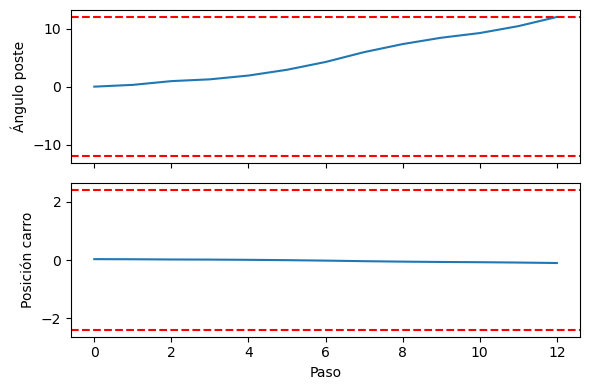

In [6]:
fig, ax = plt.subplots(2, figsize=(6, 4), tight_layout=True, sharex=True)
ax[0].plot(np.array(states)[:, 2]*180/np.pi)
ax[0].axhline(12, ls='--', c='r')
ax[0].axhline(-12, ls='--', c='r')
ax[0].set_ylabel('Ángulo poste')
ax[1].plot(np.array(states)[:, 0])
ax[1].axhline(2.4, ls='--', c='r')
ax[1].axhline(-2.4, ls='--', c='r')
ax[1].set_ylabel('Posición carro')
ax[1].set_xlabel('Paso');

## Discretización de estados

¿Es posible utilizar Q-learning si el espacio es continuo?

> Si, pero necesitamos discretizar el estado para poder construir nuestra tabla Q

Debemos decidir:

- el rango de las variables
- la resolución de las variables

En este caso particular:

- La posición del carro y el ángulo de la barra están acotadas
- La velocidad del carro y la velocidad angular de la barra no están acotadas

En base a esto creamos una función auxiliar que discretiza el espacio de estados

In [7]:
import numpy as np

def create_bin_limits(bounds, n_bins):
    return np.linspace(bounds[0], bounds[1], n_bins-1)

#n_bins = (100, 100, 100, 100) 
n_bins = (10, 10, 10, 10) 
#n_bins = (1, 1, 10, 10) 

# bins for x
x_limits = create_bin_limits((-2.4, 2.4), n_bins[0])
display(x_limits)
# bins for v
v_limits = create_bin_limits((-2.4, 2.4), n_bins[1])
display(v_limits)
# bins for t
t_limits = create_bin_limits((-15*np.pi/180, 15*np.pi/180), n_bins[2])
display(t_limits*180/np.pi) 
# bins for w
w_limits = create_bin_limits((-50*np.pi/180, 50*np.pi/180), n_bins[3])
display(w_limits*180/np.pi)

print(f"Cantidad de estados {np.prod(np.array(n_bins))}")

# Función para obtener estado discreto
def get_state(state):
    x, v, t, w = state
    x_state = np.searchsorted(x_limits, x)
    v_state = np.searchsorted(v_limits, v)
    t_state = np.searchsorted(t_limits, t)
    w_state = np.searchsorted(w_limits, w)
    return (x_state, v_state, t_state, w_state)

array([-2.4, -1.8, -1.2, -0.6,  0. ,  0.6,  1.2,  1.8,  2.4])

array([-2.4, -1.8, -1.2, -0.6,  0. ,  0.6,  1.2,  1.8,  2.4])

array([-15.  , -11.25,  -7.5 ,  -3.75,   0.  ,   3.75,   7.5 ,  11.25,
        15.  ])

array([-50. , -37.5, -25. , -12.5,   0. ,  12.5,  25. ,  37.5,  50. ])

Cantidad de estados 10000


:::{note}

- El tamaño del espacio de estados crece muy rápido con la cantidad de bines
- Las variables de estados no tienen que tener la misma resolución
- Los bines no tienen porque ser del mismo tamaño

:::

## Entrenamiento con Epsilon-Greedy Q-Learning

In [8]:
%%time

env = gym.make("CartPole-v1", render_mode="rgb_array")
Q = np.zeros(shape=(n_bins[0], n_bins[1], n_bins[2], n_bins[3],  env.action_space.n))
diagnostics = {'rewards': [], 'episode_length': []}
alpha, gamma, episodes = 0.1, 0.999, 10_000
epsilon_init, epsilon_end, epsilon_rate = 1.0, 0.01, 1e-3
epsilon = lambda episode : epsilon_end + (epsilon_init - epsilon_end) * np.exp(-epsilon_rate*episode) 
#epsilon = lambda episode : 0
n_evaluations = 10
np.random.seed(1234)

for episode in range(episodes):
    env.reset()
    terminated, truncated = False, False
    while not terminated and not truncated:        
        s_current = get_state(env.state) 
        if not np.random.binomial(1, p=1.-epsilon(episode)) and ~np.all(Q[s_current]==0): 
            a = np.argmax(Q[s_current])  
        else:
            a = env.action_space.sample() 
        s, r, terminated, truncated, info = env.step(a)
        s_future = get_state(s) 
        Q[s_current][a] += alpha*(r + gamma*np.max(Q[s_future]) - Q[s_current][a]) 
        
    if np.mod(episode+1, 100) == 0:
        diagnostics['rewards'].append(np.zeros(shape=(n_evaluations,)))
        diagnostics['episode_length'].append(np.zeros(shape=(n_evaluations,)))
        for k in range(n_evaluations):
            env.reset()    
            terminated, truncated = False, False
            episode_length, episode_reward = 0, 0.0
            while not terminated and not truncated:        
                s_current = get_state(env.state)
                a = np.argmax(Q[s_current])  
                s_future, r, terminated, truncated, info = env.step(a)
                episode_length += 1
                episode_reward += r            
            diagnostics['rewards'][-1][k] = episode_reward
            diagnostics['episode_length'][-1][k] = episode_length

CPU times: user 35.4 s, sys: 19.9 ms, total: 35.4 s
Wall time: 35.6 s


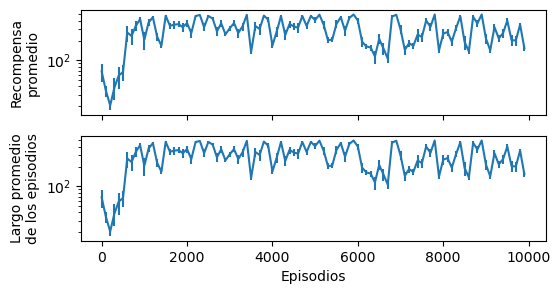

In [9]:
fig, ax = plt.subplots(2, figsize=(6, 3), sharex=True)
episodes = np.arange((episode+1)//100)*100
ax[0].errorbar(episodes,
               np.array(diagnostics['rewards']).mean(axis=1), 
               np.array(diagnostics['rewards']).std(axis=1)/np.sqrt(n_evaluations));
ax[0].set_ylabel('Recompensa\npromedio');
ax[1].errorbar(episodes,
               np.array(diagnostics['episode_length']).mean(axis=1), 
               np.array(diagnostics['episode_length']).std(axis=1)/np.sqrt(n_evaluations));
ax[1].set_xlabel('Episodios')
ax[1].set_ylabel('Largo promedio\nde los episodios');
ax[0].set_yscale('log')
ax[1].set_yscale('log')

**Probando nuestro agente**

In [10]:
env = gym.make("CartPole-v1", render_mode="human")

env.reset()
states = []
for k in range(500):
    env.render()
    states.append(env.state)
    s_current = get_state(env.state)
    a = np.argmax(Q[s_current])  
    s_future, r, terminated, truncated, info = env.step(a)
    if terminated:
        break
display(terminated, k)

True

341

In [11]:
env.close()

Seguimiento de los estados durante un episodio

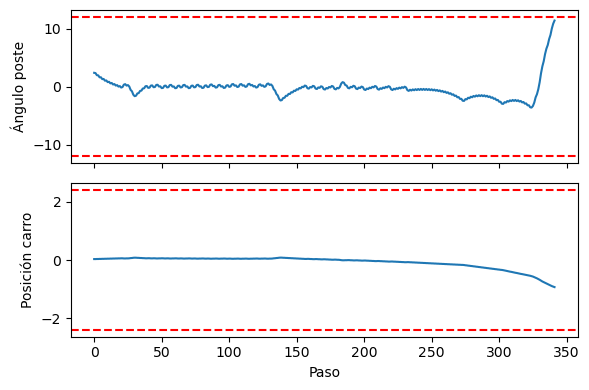

In [12]:
fig, ax = plt.subplots(2, figsize=(6, 4), tight_layout=True, sharex=True)
ax[0].plot(np.array(states)[:, 2]*180/np.pi)
ax[0].axhline(12, ls='--', c='r')
ax[0].axhline(-12, ls='--', c='r')
ax[0].set_ylabel('Ángulo poste')
ax[1].plot(np.array(states)[:, 0])
ax[1].axhline(2.4, ls='--', c='r')
ax[1].axhline(-2.4, ls='--', c='r')
ax[1].set_ylabel('Posición carro')
ax[1].set_xlabel('Paso');

**Actividad formativa:** Estudie la influencia de la resolución de los estados.

- Estudie que ocurre usando 100 bines en lugar de 10
- Luego estudie que ocurre cuando se usa 1 sólo bin para la posición y para la velocidad

## Desafios en RL

- Formular adecuadamente los estados, acciones y recompensa
- Controlar el balance entre exploración y explotación
- Obtener datos que representen la tarea